In [868]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import warnings
import numpy as np
import scipy.stats as ss

from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector
from sklearn.preprocessing import MinMaxScaler
from fancyimpute import KNN
from sklearn.impute import KNNImputer
from fancyimpute import IterativeImputer
from scipy.stats import chi2_contingency


In [869]:
data = pd.read_csv('../raw_data/dataset.csv',sep=';')
data = data.copy()
data.head()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,...,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,NaN


In [870]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   uuid                                 99976 non-null  object 
 1   default                              89976 non-null  float64
 2   account_amount_added_12_24m          99976 non-null  int64  
 3   account_days_in_dc_12_24m            88140 non-null  float64
 4   account_days_in_rem_12_24m           88140 non-null  float64
 5   account_days_in_term_12_24m          88140 non-null  float64
 6   account_incoming_debt_vs_paid_0_24m  40661 non-null  float64
 7   account_status                       45603 non-null  float64
 8   account_worst_status_0_3m            45603 non-null  float64
 9   account_worst_status_12_24m          33215 non-null  float64
 10  account_worst_status_3_6m            42274 non-null  float64
 11  account_worst_status_6_12m  

## 1. Preprocessing workflow 

In [871]:
# dropping the target variable
target = data['default']
data.drop(columns = ['default'], inplace=True)

### 1.1. Duplicates


In [872]:
# Duplicates
duplicate_count = data.duplicated().sum()
duplicate_count

0

 ### 1.2. Missing values 

In [873]:
# Missing data percentage
round((data.isnull().sum()/len(data)).sort_values(ascending=False),2)

worst_status_active_inv                0.70
account_worst_status_12_24m            0.67
account_worst_status_6_12m             0.60
account_incoming_debt_vs_paid_0_24m    0.59
account_worst_status_3_6m              0.58
account_worst_status_0_3m              0.54
account_status                         0.54
avg_payment_span_0_3m                  0.49
avg_payment_span_0_12m                 0.24
num_active_div_by_paid_inv_0_12m       0.23
num_arch_written_off_12_24m            0.18
num_arch_written_off_0_12m             0.18
account_days_in_rem_12_24m             0.12
account_days_in_term_12_24m            0.12
account_days_in_dc_12_24m              0.12
sum_paid_inv_0_12m                     0.00
sum_capital_paid_account_12_24m        0.00
sum_capital_paid_account_0_12m         0.00
time_hours                             0.00
status_max_archived_0_24_months        0.00
status_max_archived_0_12_months        0.00
status_max_archived_0_6_months         0.00
status_3rd_last_archived_0_24m  

In [874]:
_ = round((data.isnull().sum()/len(data)).sort_values(ascending=False),2)
miss_val_features_df = pd.DataFrame(_,columns=['percentage']).reset_index(names=['features'])
miss_val_features_df[miss_val_features_df['percentage'] >= 0.01]

,features,percentage
0,worst_status_active_inv,0.70
1,account_worst_status_12_24m,0.67
2,account_worst_status_6_12m,0.60
3,account_incoming_debt_vs_paid_0_24m,0.59
4,account_worst_status_3_6m,0.58
5,account_worst_status_0_3m,0.54
6,account_status,0.54
7,avg_payment_span_0_3m,0.49
8,avg_payment_span_0_12m,0.24
9,num_active_div_by_paid_inv_0_12m,0.23


### 1.3. Detect the MCAR pattern

Text(0.5, 1.0, 'Correlation between features')

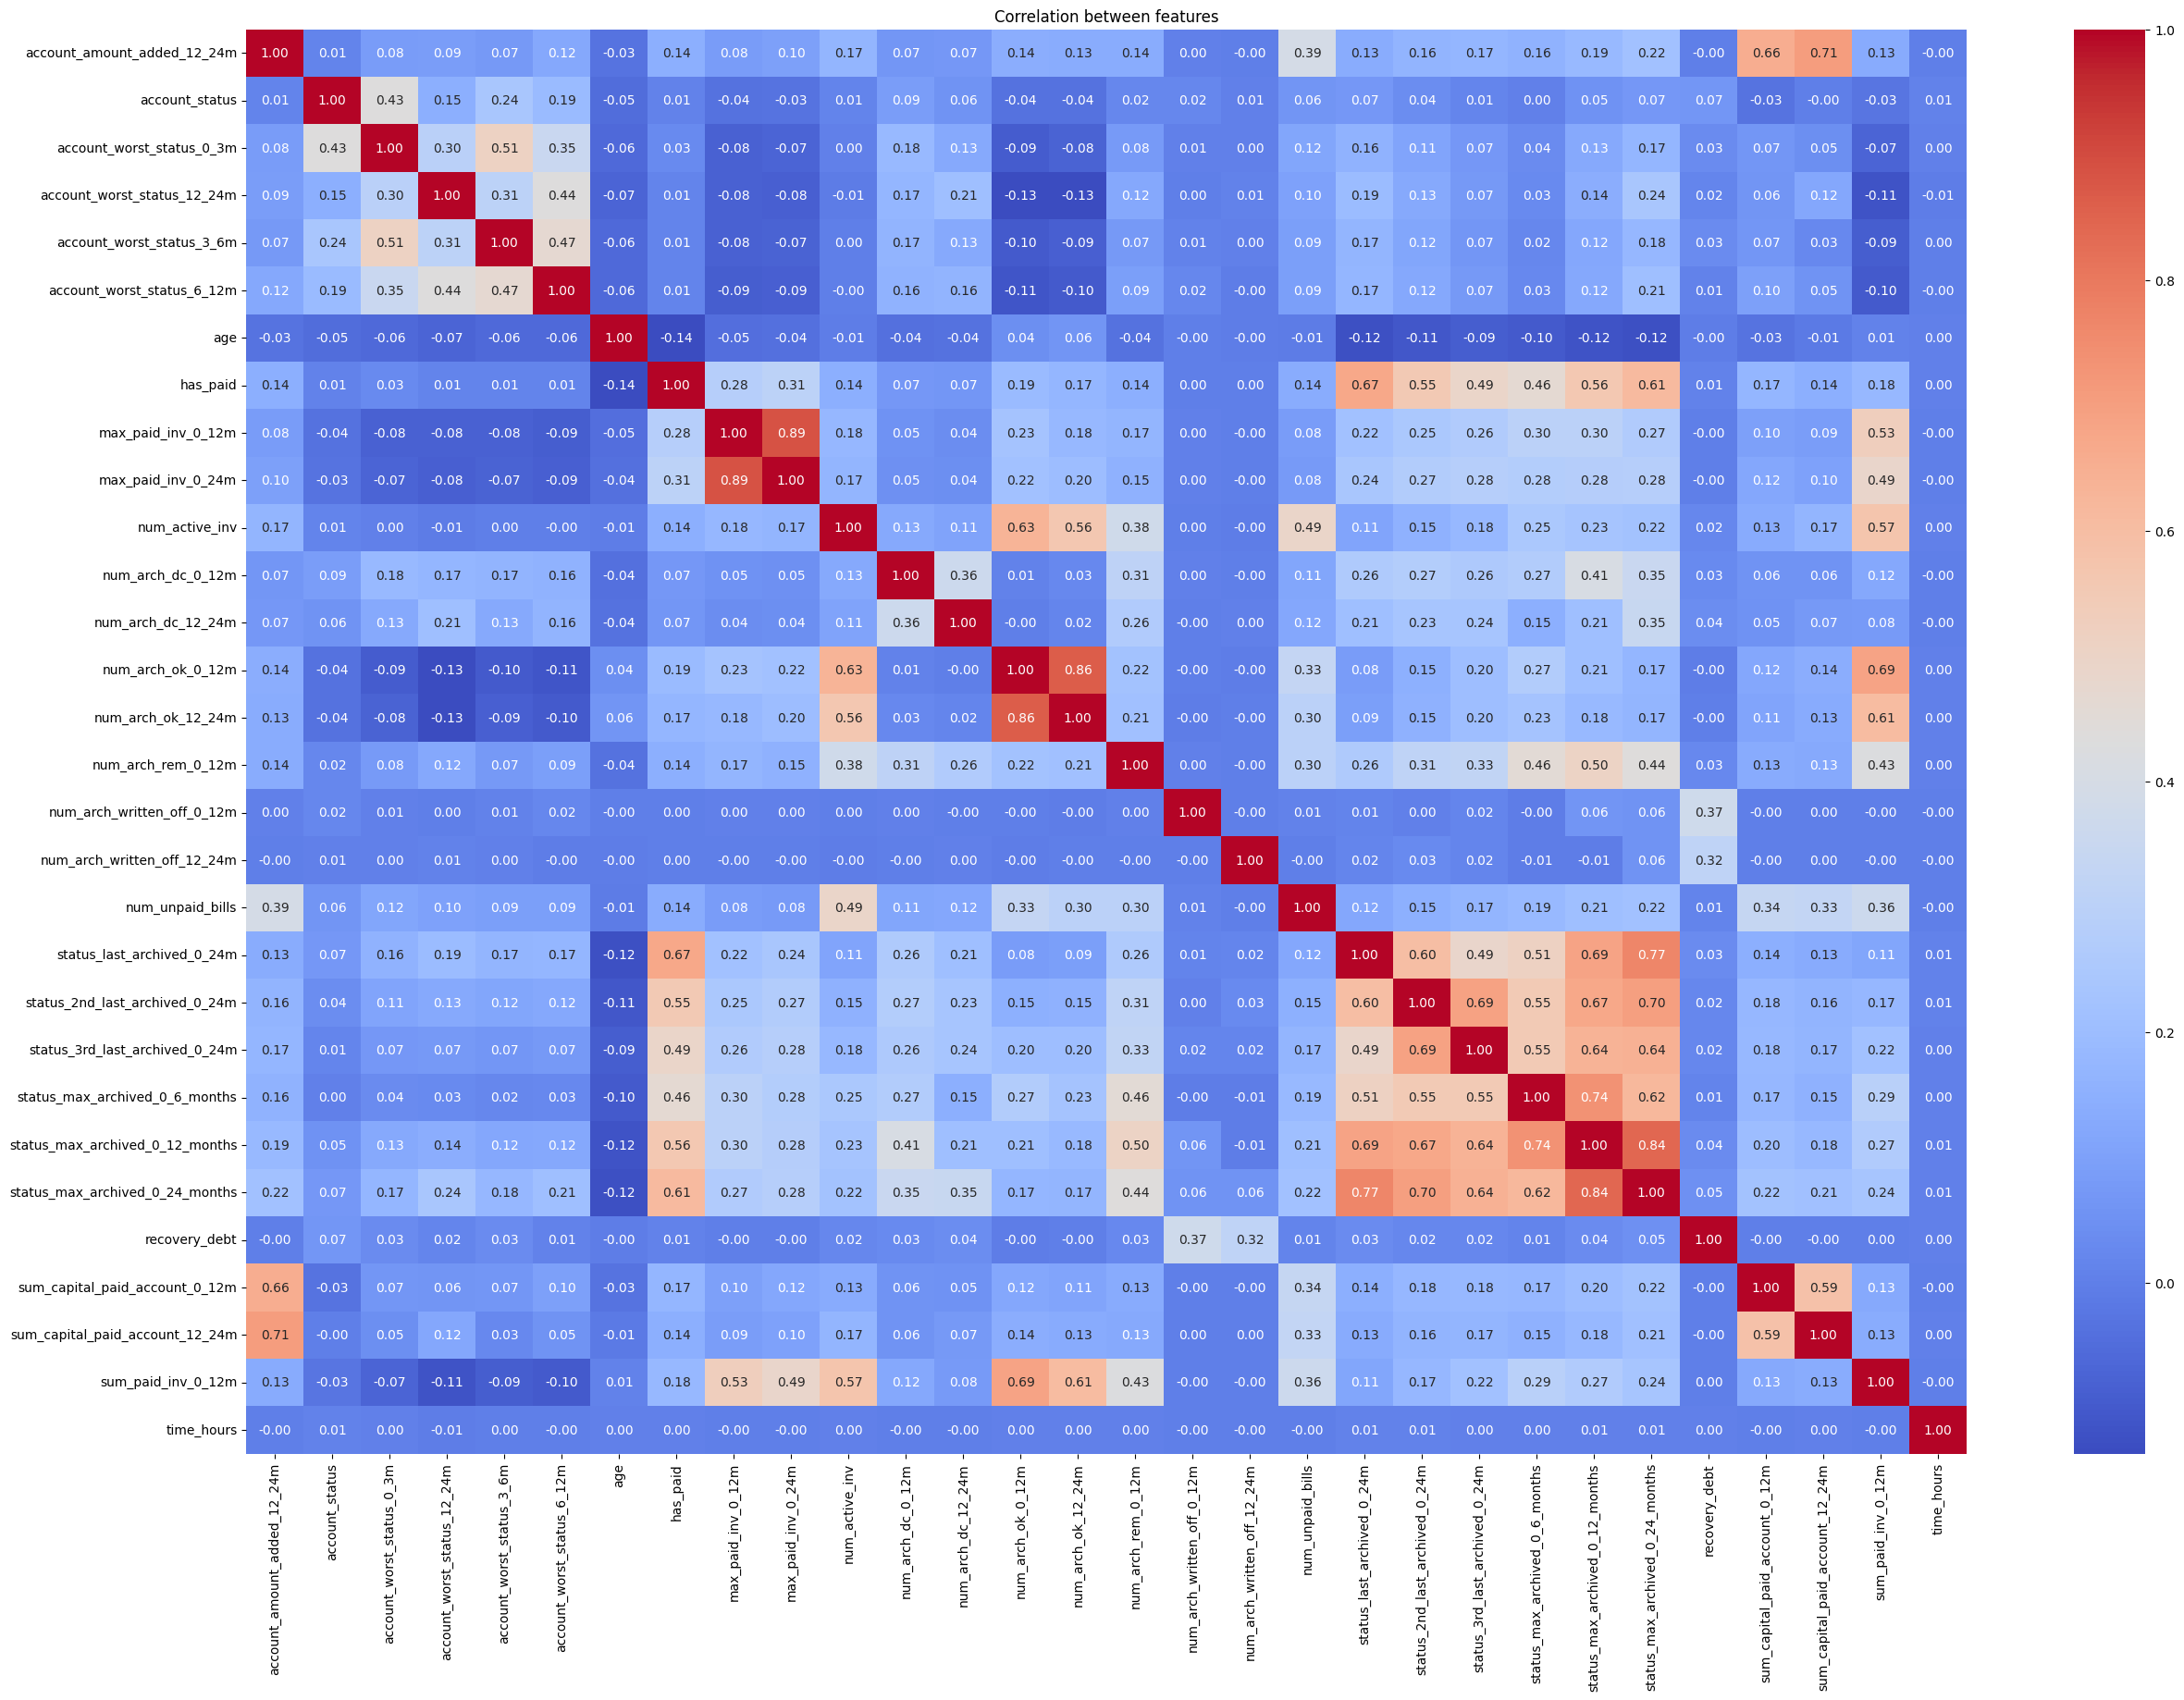

In [914]:
# first lest check correlation between features applying a heatmap
# Plot heatmap 
correlation = data.corr()
plt.figure(figsize = (30, 20))
sns.heatmap(correlation, annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.title('Correlation between features')
f"we have corraltion amonge the features and e"

In [915]:
# Age correlation with other features
correlation['age'].sort_values(ascending = False)[1:]

num_arch_ok_12_24m                 0.059812
num_arch_ok_0_12m                  0.044730
sum_paid_inv_0_12m                 0.007095
time_hours                         0.001657
num_arch_written_off_0_12m        -0.002376
num_arch_written_off_12_24m       -0.003616
recovery_debt                     -0.004624
num_active_inv                    -0.005068
num_unpaid_bills                  -0.009770
sum_capital_paid_account_12_24m   -0.012174
sum_capital_paid_account_0_12m    -0.032452
account_amount_added_12_24m       -0.033092
num_arch_rem_0_12m                -0.036696
num_arch_dc_12_24m                -0.036729
num_arch_dc_0_12m                 -0.039592
max_paid_inv_0_24m                -0.041692
max_paid_inv_0_12m                -0.046753
account_status                    -0.051441
account_worst_status_0_3m         -0.057445
account_worst_status_3_6m         -0.057898
account_worst_status_6_12m        -0.058738
account_worst_status_12_24m       -0.073132
status_3rd_last_archived_0_24m  

> #### Detecting a MCAR pattern we can use statistical tests.
> #### We can use the qui-square test to test the goodness of fit, homogenity and independence 
> #### let's the first feature "worst_status_active_inv"
> #### alpha = 0.05 - the critical value 
> #### H_0: there is no association the chosen feature and the other ones


In [875]:
# The column is false
# data["account_incoming_debt_vs_paid_0_24m"] = False
# Replace where Height_missing with True where Height is missing
# data.loc[data[data["account_incoming_debt_vs_paid_0_24m"].isnull()].index, "account_incoming_debt_vs_paid_0_24m"] == True
data.loc[data["account_incoming_debt_vs_paid_0_24m"].isnull(), "account_incoming_debt_vs_paid_0_24m"] = True
data.loc[data["account_incoming_debt_vs_paid_0_24m"] != True, "account_incoming_debt_vs_paid_0_24m"] = False

> #### Let's see if the missing values of "account_worst_status_12_24m" are correlated with "sum_paid_inv_0_12m", which does not have missing values 

In [876]:
_ = data[data["account_incoming_debt_vs_paid_0_24m"]==False].groupby("merchant_group")["account_incoming_debt_vs_paid_0_24m"].count().value_counts().keys()
false_list = np.array(_)
false_list

array([  305,  2456,  8717,  1274, 17304,   308,   165,  3194,  1601,
         432,   536,  4365])

In [877]:
true_list = data[data["account_incoming_debt_vs_paid_0_24m"]==True].groupby("merchant_group")["account_incoming_debt_vs_paid_0_24m"].count().value_counts().keys()
true_list
# if len(true_list) == 0:
#    true_list = np.array(len(true_list))
#    true_list = np.zeros(false_list.shape)
# else:
#    true_list = np.array(true_list)

Int64Index([632, 2652, 8011, 1760, 31475, 439, 199, 4162, 2117, 690, 522,
            6660],
           dtype='int64')

In [878]:
# primeiro passo
# tenho de fazer o seguinte para as listas falsas e verdadeiras
# mesmo que seja zero a count é necessário que apareça 
# true_list e false_list têm de ter a mesma shape, sempre. 
# segundo passo 
# obter o p-value para todas as categorias

In [879]:
table = []
table.append(true_list)
table.append(false_list)


In [880]:
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(table)

In [881]:
print("The p-value is esqual to {}".format(p))

The p-value is esqual to 0.0


> #### Conclusion: We reject the null hypothesys. So, we **CANNOT** say there is **no association** they're independent

> #### Lets do the same for all features 

In [882]:
# selecting only the missing values features 
missing_features_only = miss_val_features_df[miss_val_features_df['percentage'] >= 0.1]['features']
missing_features_only


0                 worst_status_active_inv
1             account_worst_status_12_24m
2              account_worst_status_6_12m
3     account_incoming_debt_vs_paid_0_24m
4               account_worst_status_3_6m
5               account_worst_status_0_3m
6                          account_status
7                   avg_payment_span_0_3m
8                  avg_payment_span_0_12m
9        num_active_div_by_paid_inv_0_12m
10            num_arch_written_off_12_24m
11             num_arch_written_off_0_12m
12             account_days_in_rem_12_24m
13            account_days_in_term_12_24m
14              account_days_in_dc_12_24m
Name: features, dtype: object

In [883]:
# analysing these missing values features
# below one can see the "account...status" are discrete
for i in missing_features_only[0:6+1]:
    print(data[missing_features_only][i].unique())

[ 1. nan  2.  3.]
[nan  1.  2.  3.  4.]
[nan  1.  3.  2.  4.]
[False True]
[ 1. nan  2.  3.  4.]
[ 1. nan  2.  3.  4.]
[ 1. nan  2.  3.  4.]


In [884]:
# as we can see the next some of the other features are also discrete
for i in missing_features_only[7:]:
    print(len(data[missing_features_only][i].unique()))
    

2257
7940
862
4
3
283
65
128


In [885]:
# according to what we said in "Dataset_explanation.ipynb" 
# these features means "number of archieved invoices that were unpaid between M and N months ago"
# I am attempted to consider them as discrete feature given the values we have
# probably, we have an upper limit for this situation. Meaning, customers are not allowed to have more than 2 unpaid invoices for a period of 24 months
# or 1 unpaid invoice for a period of 12 months
for i in missing_features_only[10:11+1]:
    print(data[missing_features_only][i].unique())

[ 0. nan  2.  1.]
[ 0. nan  1.]


In [886]:
# lets go further on this 
data[['uuid','num_arch_written_off_0_12m', 'num_arch_written_off_12_24m']][(data['num_arch_written_off_12_24m']  > 0) | (data['num_arch_written_off_0_12m'] > 0)]

,uuid,num_arch_written_off_0_12m,num_arch_written_off_12_24m
4736,fe583a43-ee49-4268-8ce5-1b1c53c38a0a,1.0,0.0
11939,0acd2796-3f77-4ce7-97ff-e3443d528fc7,1.0,0.0
19795,9b254660-b084-40b3-8e53-a2d11081f945,0.0,2.0
25071,08c0505e-a202-4627-970c-0e400af3807a,1.0,0.0
30081,cfb183fc-a502-408d-815d-cb9a4da3e110,0.0,1.0
44171,911b27da-977a-48bf-9354-548d3a52789e,0.0,1.0
50262,531f5e8e-b59b-4944-8215-4ba474a51bd2,1.0,0.0
54864,15d51024-2f68-4394-aa29-a909ed11609b,1.0,0.0
59024,9176cb03-325b-483e-9ffa-927358b782fe,0.0,1.0
59630,261e4f5e-724e-4540-b24b-73dfe1616578,1.0,0.0


In [887]:
# our discrete variables are 
discrete_missing_values = ['account_worst_status_12_24m','account_worst_status_6_12m',
                           'account_worst_status_3_6m','account_worst_status_0_3m',
                           'account_status','num_arch_written_off_12_24m',
                           'num_arch_written_off_0_12m','default']
discrete_missing_values

['account_worst_status_12_24m',
 'account_worst_status_6_12m',
 'account_worst_status_3_6m',
 'account_worst_status_0_3m',
 'account_status',
 'num_arch_written_off_12_24m',
 'num_arch_written_off_0_12m',
 'default']

In [888]:
continuos_missing_values = list(set(missing_features_only).difference(discrete_missing_values))
continuos_missing_values

['worst_status_active_inv',
 'account_days_in_term_12_24m',
 'num_active_div_by_paid_inv_0_12m',
 'account_days_in_rem_12_24m',
 'avg_payment_span_0_3m',
 'avg_payment_span_0_12m',
 'account_days_in_dc_12_24m',
 'account_incoming_debt_vs_paid_0_24m']

### 1.3.1. Feature Binning

In [889]:
def quantile(numeric_feature):
    
    numeric_feature = [float(x) for x in numeric_feature] # convert all values to float
    
    q1 = pd.Series(numeric_feature).quantile(0.25)
    q2 = pd.Series(numeric_feature).quantile(0.50)
    q3 = pd.Series(numeric_feature).quantile(0.75)
    
    for i in range(len(numeric_feature)):
        if numeric_feature[i] <= q1:
            numeric_feature[i] = '1st_quant'
        elif (numeric_feature[i] > q1) and (numeric_feature[i] <= q2):
            numeric_feature[i] = '2nd_quant'
        elif (numeric_feature[i] > q2) and (numeric_feature[i] <= q3):
            numeric_feature[i] = '3rd_quant'  
        elif numeric_feature[i] > q3:
            numeric_feature[i] = '4th_quant'
        else: 
            None
    return np.array(numeric_feature)

In [890]:
data = { i: quantile(data[i]) if i in continuos_missing_values else data[i] for i in data }


In [891]:
# Creates DataFrame.
data = pd.DataFrame(data)
data.head()

,uuid,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0,1st_quant,1st_quant,1st_quant,1st_quant,1.0,1.0,NaN,1.0,...,1,1,1,1,0,0,0,178839,9.653333,1st_quant
1,0e961183-8c15-4470-9a5e-07a1bd207661,0,1st_quant,1st_quant,1st_quant,2nd_quant,1.0,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,nan
2,d8edaae6-4368-44e0-941e-8328f203e64e,0,1st_quant,1st_quant,1st_quant,2nd_quant,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1st_quant
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0,nan,nan,nan,2nd_quant,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1st_quant
4,c8f8b835-5647-4506-bf15-49105d8af30b,0,1st_quant,1st_quant,1st_quant,2nd_quant,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,nan


In [892]:
#  isna and isnull were not recognizing "nan" 
data = data.replace('nan', np.NaN)

In [893]:
data_missing_only = {feature: data[feature] for feature in missing_features_only}
data_missing_only = pd.DataFrame(data_missing_only)
data_missing_only

,worst_status_active_inv,account_worst_status_12_24m,account_worst_status_6_12m,account_incoming_debt_vs_paid_0_24m,account_worst_status_3_6m,account_worst_status_0_3m,account_status,avg_payment_span_0_3m,avg_payment_span_0_12m,num_active_div_by_paid_inv_0_12m,num_arch_written_off_12_24m,num_arch_written_off_0_12m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_days_in_dc_12_24m
0,1st_quant,NaN,NaN,1st_quant,1.0,1.0,1.0,1st_quant,2nd_quant,4th_quant,0.0,0.0,1st_quant,1st_quant,1st_quant
1,NaN,1.0,1.0,2nd_quant,1.0,1.0,1.0,4th_quant,4th_quant,1st_quant,0.0,0.0,1st_quant,1st_quant,1st_quant
2,1st_quant,NaN,NaN,2nd_quant,NaN,NaN,NaN,3rd_quant,3rd_quant,3rd_quant,0.0,0.0,1st_quant,1st_quant,1st_quant
3,1st_quant,NaN,NaN,2nd_quant,NaN,NaN,NaN,1st_quant,1st_quant,3rd_quant,0.0,0.0,NaN,NaN,NaN
4,NaN,NaN,NaN,2nd_quant,NaN,NaN,NaN,2nd_quant,2nd_quant,1st_quant,0.0,0.0,1st_quant,1st_quant,1st_quant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99971,NaN,NaN,NaN,2nd_quant,NaN,1.0,1.0,NaN,1st_quant,1st_quant,0.0,0.0,1st_quant,1st_quant,1st_quant
99972,NaN,NaN,1.0,1st_quant,1.0,1.0,1.0,NaN,4th_quant,1st_quant,0.0,0.0,1st_quant,1st_quant,1st_quant
99973,NaN,2.0,1.0,1st_quant,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,4th_quant,1st_quant,1st_quant
99974,NaN,1.0,2.0,1st_quant,2.0,2.0,1.0,NaN,3rd_quant,1st_quant,0.0,0.0,1st_quant,1st_quant,1st_quant


In [894]:
# Transforming all missing values to "True"    
data_missing_only = data_missing_only.isna().applymap(lambda x: True if x else False)


In [895]:
data_missing_only  

,worst_status_active_inv,account_worst_status_12_24m,account_worst_status_6_12m,account_incoming_debt_vs_paid_0_24m,account_worst_status_3_6m,account_worst_status_0_3m,account_status,avg_payment_span_0_3m,avg_payment_span_0_12m,num_active_div_by_paid_inv_0_12m,num_arch_written_off_12_24m,num_arch_written_off_0_12m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_days_in_dc_12_24m
0,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,True,True,False,True,True,True,False,False,False,False,False,False,False,False
3,False,True,True,False,True,True,True,False,False,False,False,False,True,True,True
4,True,True,True,False,True,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99971,True,True,True,False,True,False,False,True,False,False,False,False,False,False,False
99972,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False
99973,True,False,False,False,False,False,False,True,True,True,True,True,False,False,False
99974,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [896]:
def getCombinations(seq):
    combinations = list()
    for i in range(len(seq)):
        for j in range(i+1,len(seq)+1):
            combinations.append([seq[i],seq[j]])
    return pd.DataFrame(combinations, columns = ['features', 'compared_with'])

# source: https://stackoverflow.com/questions/20762574/combinations-with-two-elements


In [897]:
def getCombinations(seq):
    combinations = list()
    for i in range(0,len(seq)):
        for j in range(i+1,len(seq)):
            combinations.append([seq[i],seq[j]])
    return pd.DataFrame(combinations, columns = ['features', 'compared_with'])

In [898]:
""" def getCombinations(seq):
    combinations = list()
    if len(seq) < 2:
        return pd.DataFrame(columns=['features', 'compared_with'])
    for i in range(0, len(seq)):
        for j in range(i, len(seq)):
            combinations.append([seq[i],seq[j]])
    return pd.DataFrame(combinations, columns = ['features', 'compared_with']) """

" def getCombinations(seq):\n    combinations = list()\n    if len(seq) < 2:\n        return pd.DataFrame(columns=['features', 'compared_with'])\n    for i in range(0, len(seq)):\n        for j in range(i, len(seq)):\n            combinations.append([seq[i],seq[j]])\n    return pd.DataFrame(combinations, columns = ['features', 'compared_with']) "

In [899]:
all_combinations = getCombinations(data_missing_only.columns)
all_combinations = getCombinations(data_missing_only.columns)
len(all_combinations)

# note:
# nCr = 15! / 2!(15-2)!
# nCr = 105


105

In [900]:
f"length must be 15 and got {all_combinations['features'].unique().shape[0]}"

'length must be 15 and got 14'

In [901]:
confusion_matrix = []
for index in range(0, len(all_combinations)):
    confusion_matrix.append(pd.crosstab(data_missing_only[all_combinations['features'][index]], data_missing_only[all_combinations['compared_with'][index]]))

In [902]:
all_combinations['p_value'] = [round(ss.chi2_contingency(confusion_matrix[index])[1],3) for index in range(len(all_combinations))]
all_combinations


,features,compared_with,p_value
0,worst_status_active_inv,account_worst_status_12_24m,0.000
1,worst_status_active_inv,account_worst_status_6_12m,0.000
2,worst_status_active_inv,account_incoming_debt_vs_paid_0_24m,1.000
3,worst_status_active_inv,account_worst_status_3_6m,0.000
4,worst_status_active_inv,account_worst_status_0_3m,0.000
...,...,...,...
100,num_arch_written_off_0_12m,account_days_in_term_12_24m,0.002
101,num_arch_written_off_0_12m,account_days_in_dc_12_24m,0.002
102,account_days_in_rem_12_24m,account_days_in_term_12_24m,0.000
103,account_days_in_rem_12_24m,account_days_in_dc_12_24m,0.000


In [903]:
# p_values above the alpha of 5%
all_combinations['p_value'][all_combinations['p_value']>0.05].count()

26

In [904]:
all_combinations['null rej'] = all_combinations['p_value'].apply(lambda x: 'No' if x > 0.05 else 'Yes')


In [905]:
all_combinations['dependence'] = all_combinations['p_value'].apply(lambda x: 'Dependent' if x < 0.05 else 'Independent') 
all_combinations
# source: https://towardsdatascience.com/statistical-test-for-mcar-in-python-9fb617a76eac

,features,compared_with,p_value,null rej,dependence
0,worst_status_active_inv,account_worst_status_12_24m,0.000,Yes,Dependent
1,worst_status_active_inv,account_worst_status_6_12m,0.000,Yes,Dependent
2,worst_status_active_inv,account_incoming_debt_vs_paid_0_24m,1.000,No,Independent
3,worst_status_active_inv,account_worst_status_3_6m,0.000,Yes,Dependent
4,worst_status_active_inv,account_worst_status_0_3m,0.000,Yes,Dependent
...,...,...,...,...,...
100,num_arch_written_off_0_12m,account_days_in_term_12_24m,0.002,Yes,Dependent
101,num_arch_written_off_0_12m,account_days_in_dc_12_24m,0.002,Yes,Dependent
102,account_days_in_rem_12_24m,account_days_in_term_12_24m,0.000,Yes,Dependent
103,account_days_in_rem_12_24m,account_days_in_dc_12_24m,0.000,Yes,Dependent


In [906]:
# most of our features are correlated 
all_combinations[all_combinations['dependence'] == 'Dependent']


,features,compared_with,p_value,null rej,dependence
0,worst_status_active_inv,account_worst_status_12_24m,0.000,Yes,Dependent
1,worst_status_active_inv,account_worst_status_6_12m,0.000,Yes,Dependent
3,worst_status_active_inv,account_worst_status_3_6m,0.000,Yes,Dependent
4,worst_status_active_inv,account_worst_status_0_3m,0.000,Yes,Dependent
5,worst_status_active_inv,account_status,0.000,Yes,Dependent
...,...,...,...,...,...
100,num_arch_written_off_0_12m,account_days_in_term_12_24m,0.002,Yes,Dependent
101,num_arch_written_off_0_12m,account_days_in_dc_12_24m,0.002,Yes,Dependent
102,account_days_in_rem_12_24m,account_days_in_term_12_24m,0.000,Yes,Dependent
103,account_days_in_rem_12_24m,account_days_in_dc_12_24m,0.000,Yes,Dependent


In [907]:
# these are the uncorrelated cases
all_combinations[all_combinations['dependence'] == 'Independent']

,features,compared_with,p_value,null rej,dependence
2,worst_status_active_inv,account_incoming_debt_vs_paid_0_24m,1.000,No,Independent
11,worst_status_active_inv,account_days_in_rem_12_24m,0.548,No,Independent
12,worst_status_active_inv,account_days_in_term_12_24m,0.548,No,Independent
13,worst_status_active_inv,account_days_in_dc_12_24m,0.548,No,Independent
15,account_worst_status_12_24m,account_incoming_debt_vs_paid_0_24m,1.000,No,Independent
27,account_worst_status_6_12m,account_incoming_debt_vs_paid_0_24m,1.000,No,Independent
39,account_incoming_debt_vs_paid_0_24m,account_worst_status_3_6m,1.000,No,Independent
40,account_incoming_debt_vs_paid_0_24m,account_worst_status_0_3m,1.000,No,Independent
41,account_incoming_debt_vs_paid_0_24m,account_status,1.000,No,Independent
42,account_incoming_debt_vs_paid_0_24m,avg_payment_span_0_3m,1.000,No,Independent


In [908]:
# "account_incoming_debt_vs_paid_0_24m" is independent on other features
# tenho de criar um funçao/codigo para saber o número de relações que cada feature tem com as outras. 
# por ex. "account_incoming_debt_vs_paid_0_24m" esta feature não tem nenhuma, mas uma poderia ter uma, logo, o metódo a plicar será diferente. 
# Aqui provavelmente podemos ultilizar de acordo o GPT,
### 1. simple imputation 
### 2. knn
### 3. Penso que podemos ver a possibilidade de remover esta feature. (estou a pensar)

In [909]:
dependence_count = []
for i in range(len(all_combinations['features'])-1):
    if all_combinations['features'][i+1] != all_combinations['features'][i]:
        feature = all_combinations['features'][i]
        dependent_count = all_combinations[(all_combinations['features'] == feature) & (all_combinations['dependence'] == 'Dependent')].shape[0]
        independent_count = all_combinations[(all_combinations['features'] == feature) & (all_combinations['dependence'] == 'Independent')].shape[0]
        dependence_count.append({'features': feature, 'dependence_count': dependent_count, 'independent_count': independent_count})

dependence_df = pd.DataFrame(dependence_count)

# Add the last row
dependence_df.loc[len(dependence_count)] = [all_combinations['features'].iloc[-1], 
                                            all_combinations[(all_combinations['features'] == all_combinations['features'].iloc[-1]) & (all_combinations['dependence'] == 'Dependent')].shape[0],
                                            all_combinations[(all_combinations['features'] == all_combinations['features'].iloc[-1]) & (all_combinations['dependence'] == 'Independent')].shape[0]]

# the above formula has a limitation in its analysis, it only compares "features" against "compared_with" 
# and it should be considered the way around to make more evident features relationships. Nevertheless, we can still see that dependence

In [910]:
dependence_df

,features,dependence_count,independent_count
0,worst_status_active_inv,10,4
1,account_worst_status_12_24m,12,1
2,account_worst_status_6_12m,11,1
3,account_incoming_debt_vs_paid_0_24m,0,11
4,account_worst_status_3_6m,10,0
5,account_worst_status_0_3m,9,0
6,account_status,8,0
7,avg_payment_span_0_3m,4,3
8,avg_payment_span_0_12m,3,3
9,num_active_div_by_paid_inv_0_12m,2,3


In [913]:
# lets take the first case as an example. 
# these two features are considered dependent - "worst_status_active_inv" and "account_worst_status_12_24m"
# recap: "worst_status_active_inv" it's the worst status of the client 
# recap: "account_worst_status_12_24m" it's the worst status from 12 months to 24 months
# by just reading the features explations we can figure they're correlated 
## ###
# Now lets check on an independent case
# these two features are considered independent - "avg_payment_span_0_3m" and "account_days_in_rem_12_24m"
# recap: "avg_payment_span_0_3m" it's "the average number of days to liquidate debt looking back between M and  N months ago"
# recap: "account_days_in_rem_12_24m" it's "number of days an account was put into status "rem" between M and N months ago". 
#        "rem" it may refer to an account that is in "reminder or collection phase" of a process of attempting to collect payments that are past due
#         it may involves sending reminders or notices. 
# so, looking at the above explaination these two features are correlated at all. Once, the first one refes to the number of days liquidate debt 
# while the other one refers to the number of days to liquidate a debt that are past due and this seems to be the first phase, which is just sending reminders
# We can conclude there is an inherent relationship between for most of the variables that have missing values in our dataset,
# the data is considered Missing at Random (MAR), so we can apply imputation technique like “mode” imputation or go for a slightly advanced technique like Multiple Imputation.
# 
# Aditionally, we could apply the same test for the whole dataset 


In [912]:
# 1 read chatgpt -  code explanations - ok 
# 2 read this article and apply the above to it - ok 
# 3 ver celula 555, criar função - ok 
# 4 please!!! I have to start the imputation - next step - read some browsers tabs
### the last 3 features of "dependence_df" I can use the mode of the ones to get the values 
